In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile
import hashlib

In [3]:
def _unzip(save_path, _, database_name, data_path):
    """
    Unzip wrapper with the same interface as _ungzip
    :param save_path: The path of the gzip files
    :param database_name: Name of database
    :param data_path: Path to extract to
    :param _: HACK - Used to have to same interface as _ungzip
    """
    print('Extracting {}...'.format(database_name))
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_path)

def download_extract(database_name, data_path):
    """
    Download and extract database
    :param database_name: Database name
    """
    DATASET_ML1M = 'ml-1m'

    if database_name == DATASET_ML1M:
        url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
        hash_code = 'c4d9eecfca2ab87c1945afe126590906'
        extract_path = os.path.join(data_path, 'ml-1m')
        save_path = os.path.join(data_path, 'ml-1m.zip')
        extract_fn = _unzip

    if os.path.exists(extract_path):
        print('Found {} Data'.format(database_name))
        return

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(save_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(database_name)) as pbar:
            urlretrieve(
                url,
                save_path,
                pbar.hook)

    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
        '{} file is corrupted.  Remove the file and try again.'.format(save_path)

    os.makedirs(extract_path)
    try:
        extract_fn(save_path, extract_path, database_name, data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err

    print('Done.')
    # Remove compressed data
#     os.remove(save_path)

class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        :param block_num: A count of blocks transferred so far
        :param block_size: Block size in bytes
        :param total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                            a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [4]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [5]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


评分数据
分别有用户ID、电影ID、评分和时间戳等字段。

数据中的格式：UserID::MovieID::Rating::Timestamp



In [6]:
ratings_title= ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
def load_data():
    """
    Load Dataset from File
    """
    #读取User数据
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_orig = users.values
    #改变User数据中性别和年龄
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)

    age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)

    #读取Movie数据集
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
    movies_orig = movies.values
    #将Title中的年份去掉
    pattern = re.compile(r'^(.*)\((\d+)\)$')

    title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_map)

    #电影类型转数字字典
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)

    genres_set.add('<PAD>')
    genres2int = {val:ii for ii, val in enumerate(genres_set)}

    #将电影类型转成等长数字列表，长度是18
    genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    
    movies['Genres'] = movies['Genres'].map(genres_map)

    #电影Title转数字字典
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    
    title_set.add('<PAD>')
    title2int = {val:ii for ii, val in enumerate(title_set)}

    #将电影Title转成等长数字列表，长度是15
    title_count = 15
    title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    
    movies['Title'] = movies['Title'].map(title_map)

    #读取评分数据集
    ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')

    #合并三个表
    data = pd.merge(pd.merge(ratings, users), movies)
    
    #将数据分成X和y两张表
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig

In [8]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()

pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('preprocess.p', 'wb'))

In [9]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [10]:
movies.head()

,MovieID,Title,Genres
0,1,"[2527, 4617, 1434, 1434, 1434, 1434, 1434, 143...","[9, 10, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16,..."
1,2,"[47, 1434, 1434, 1434, 1434, 1434, 1434, 1434,...","[14, 10, 15, 16, 16, 16, 16, 16, 16, 16, 16, 1..."
2,3,"[3706, 4698, 4401, 1434, 1434, 1434, 1434, 143...","[7, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,..."
3,4,"[896, 4253, 3898, 1434, 1434, 1434, 1434, 1434...","[7, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,..."
4,5,"[4468, 2727, 3264, 5186, 2078, 755, 1434, 1434...","[7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16..."


In [11]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('preprocess.p', mode='rb'))

In [12]:
import tensorflow as tf
import os
import pickle

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))

In [13]:
#嵌入矩阵的维度
embed_dim = 32
#用户ID个数
uid_max = max(features.take(0,1)) + 1 # 6040
#性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3952
#电影类型个数
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
movie_title_max = len(title_set) # 5216

#对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#电影名长度
sentences_size = title_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

In [14]:
# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256

dropout_keep = 0.5
# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 20

save_dir = './save'

输入
定义输入的占位符

In [15]:
def get_inputs():
    uid = tf.placeholder(tf.int32, [None, 1], name="uid")
    user_gender = tf.placeholder(tf.int32, [None, 1], name="user_gender")
    user_age = tf.placeholder(tf.int32, [None, 1], name="user_age")
    user_job = tf.placeholder(tf.int32, [None, 1], name="user_job")
    
    movie_id = tf.placeholder(tf.int32, [None, 1], name="movie_id")
    movie_categories = tf.placeholder(tf.int32, [None, 18], name="movie_categories")
    movie_titles = tf.placeholder(tf.int32, [None, 15], name="movie_titles")
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

In [16]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    with tf.name_scope("user_embedding"):
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name = "uid_embed_matrix")
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name = "uid_embed_layer")
    
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_max, embed_dim // 2], -1, 1), name= "gender_embed_matrix")
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name = "gender_embed_layer")
        
        age_embed_matrix = tf.Variable(tf.random_uniform([age_max, embed_dim // 2], -1, 1), name="age_embed_matrix")
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name="age_embed_layer")
        
        job_embed_matrix = tf.Variable(tf.random_uniform([job_max, embed_dim // 2], -1, 1), name = "job_embed_matrix")
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, user_job, name = "job_embed_layer")
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

In [17]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    with tf.name_scope("user_fc"):
        #第一层全连接
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu)
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name = "gender_fc_layer", activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name ="age_fc_layer", activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, name = "job_fc_layer", activation=tf.nn.relu)
        
        #第二层全连接
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
    return user_combine_layer, user_combine_layer_flat

In [18]:
def get_movie_id_embed_layer(movie_id):
    with tf.name_scope("movie_embedding"):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name = "movie_id_embed_matrix")
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name = "movie_id_embed_layer")
    return movie_id_embed_layer

In [19]:
def get_movie_categories_layers(movie_categories):
    with tf.name_scope("movie_categories_layers"):
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_max, embed_dim], -1, 1), name = "movie_categories_embed_matrix")
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name = "movie_categories_embed_layer")
        if combiner == "sum":
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True)
    #     elif combiner == "mean":

    return movie_categories_embed_layer

In [20]:
def get_movie_cnn_layer(movie_titles):
    #从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    with tf.name_scope("movie_embedding"):
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name = "movie_title_embed_layer")
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
    
    #对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    pool_layer_lst = []
    for window_size in window_sizes:
        with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")
            
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")
            
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
            pool_layer_lst.append(maxpool_layer)

    #Dropout层
    with tf.name_scope("pool_dropout"):
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")
        max_num = len(window_sizes) * filter_num
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")
    
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")
    return pool_layer_flat, dropout_layer

In [21]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    with tf.name_scope("movie_fc"):
        #第一层全连接
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)
        movie_categories_fc_layer = tf.layers.dense(movie_categories_embed_layer, embed_dim, name = "movie_categories_fc_layer", activation=tf.nn.relu)
    
        #第二层全连接
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  #(?, 1, 96)
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat

In [22]:
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    #获取输入占位符
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    #获取User的4个嵌入向量
    uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender, user_age, user_job)
    #得到用户特征
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
    #获取电影ID的嵌入向量
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    #获取电影类型的嵌入向量
    movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
    #获取电影名的特征向量
    pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
    #得到电影特征
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer, 
                                                                                movie_categories_embed_layer, 
                                                                                dropout_layer)
    #计算出评分，要注意两个不同的方案，inference的名字（name值）是不一样的，后面做推荐时要根据name取得tensor
    with tf.name_scope("inference"):
        #将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
#         inference_layer = tf.concat([user_combine_layer_flat, movie_combine_layer_flat], 1)  #(?, 200)
#         inference = tf.layers.dense(inference_layer, 1,
#                                     kernel_initializer=tf.truncated_normal_initializer(stddev=0.01), 
#                                     kernel_regularizer=tf.nn.l2_loss, name="inference")
        #简单的将用户特征和电影特征做矩阵乘法得到一个预测评分
#        inference = tf.matmul(user_combine_layer_flat, tf.transpose(movie_combine_layer_flat))
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)
        inference = tf.expand_dims(inference, axis=1)

    with tf.name_scope("loss"):
        # MSE损失，将计算值回归到评分
        cost = tf.losses.mean_squared_error(targets, inference )
        loss = tf.reduce_mean(cost)
    # 优化损失 
#     train_op = tf.train.AdamOptimizer(lr).minimize(loss)  #cost
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [23]:
inference

<tf.Tensor 'inference/ExpandDims:0' shape=(?, 1) dtype=float32>

In [24]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import datetime

losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    
    #搜集数据给tensorBoard用
    # Keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
        
    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
     
    # Summaries for loss and accuracy
    loss_summary = tf.summary.scalar("loss", loss)

    # Train Summaries
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Inference summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        
        #将数据集分成训练集和测试集，随机种子不固定
        train_X,test_X, train_y, test_y = train_test_split(features,  
                                                           targets_values,  
                                                           test_size = 0.2,  
                                                           random_state = 0)  
        
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
    
        #训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)

            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}

            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)  #
            
            # Show every <show_every_n_batches> batches
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
                
        #使用测试数据的迭代
        for batch_i  in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  #cost

            #保存测试损失
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #

            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))

    # Save Model
    saver.save(sess, save_dir)  #, global_step=epoch_i
    print('Model Trained and Saved')

Writing to F:\JupyterProjects\推荐系统\runs\1532524073

2018-07-25T21:07:57.829940: Epoch   0 Batch    0/3125   train_loss = 12.481
2018-07-25T21:07:58.967005: Epoch   0 Batch   20/3125   train_loss = 3.973
2018-07-25T21:08:00.018065: Epoch   0 Batch   40/3125   train_loss = 2.786
2018-07-25T21:08:01.124128: Epoch   0 Batch   60/3125   train_loss = 1.954
2018-07-25T21:08:02.229192: Epoch   0 Batch   80/3125   train_loss = 2.065
2018-07-25T21:08:03.302253: Epoch   0 Batch  100/3125   train_loss = 1.887
2018-07-25T21:08:04.406316: Epoch   0 Batch  120/3125   train_loss = 1.829
2018-07-25T21:08:05.545381: Epoch   0 Batch  140/3125   train_loss = 1.612
2018-07-25T21:08:06.686447: Epoch   0 Batch  160/3125   train_loss = 1.419
2018-07-25T21:08:07.863514: Epoch   0 Batch  180/3125   train_loss = 1.624
2018-07-25T21:08:08.991578: Epoch   0 Batch  200/3125   train_loss = 1.603
2018-07-25T21:08:10.118643: Epoch   0 Batch  220/3125   train_loss = 1.521
2018-07-25T21:08:11.306711: Epoch   0 Batch  24

2018-07-25T21:10:01.891036: Epoch   0 Batch 2160/3125   train_loss = 1.092
2018-07-25T21:10:03.073104: Epoch   0 Batch 2180/3125   train_loss = 1.117
2018-07-25T21:10:04.266172: Epoch   0 Batch 2200/3125   train_loss = 1.108
2018-07-25T21:10:05.414237: Epoch   0 Batch 2220/3125   train_loss = 1.151
2018-07-25T21:10:06.594305: Epoch   0 Batch 2240/3125   train_loss = 1.007
2018-07-25T21:10:07.815375: Epoch   0 Batch 2260/3125   train_loss = 1.119
2018-07-25T21:10:08.999443: Epoch   0 Batch 2280/3125   train_loss = 1.167
2018-07-25T21:10:10.193511: Epoch   0 Batch 2300/3125   train_loss = 1.164
2018-07-25T21:10:11.394580: Epoch   0 Batch 2320/3125   train_loss = 1.231
2018-07-25T21:10:12.575647: Epoch   0 Batch 2340/3125   train_loss = 1.185
2018-07-25T21:10:13.634708: Epoch   0 Batch 2360/3125   train_loss = 1.127
2018-07-25T21:10:14.721770: Epoch   0 Batch 2380/3125   train_loss = 1.143
2018-07-25T21:10:15.839834: Epoch   0 Batch 2400/3125   train_loss = 1.312
2018-07-25T21:10:16.95389

2018-07-25T21:11:34.716345: Epoch   1 Batch  435/3125   train_loss = 1.120
2018-07-25T21:11:35.816408: Epoch   1 Batch  455/3125   train_loss = 1.088
2018-07-25T21:11:36.987475: Epoch   1 Batch  475/3125   train_loss = 1.167
2018-07-25T21:11:38.122540: Epoch   1 Batch  495/3125   train_loss = 1.052
2018-07-25T21:11:39.265605: Epoch   1 Batch  515/3125   train_loss = 1.187
2018-07-25T21:11:40.427672: Epoch   1 Batch  535/3125   train_loss = 1.095
2018-07-25T21:11:41.607739: Epoch   1 Batch  555/3125   train_loss = 1.286
2018-07-25T21:11:42.745805: Epoch   1 Batch  575/3125   train_loss = 1.101
2018-07-25T21:11:43.972875: Epoch   1 Batch  595/3125   train_loss = 1.251
2018-07-25T21:11:45.181944: Epoch   1 Batch  615/3125   train_loss = 1.077
2018-07-25T21:11:46.398013: Epoch   1 Batch  635/3125   train_loss = 1.137
2018-07-25T21:11:47.603082: Epoch   1 Batch  655/3125   train_loss = 0.966
2018-07-25T21:11:48.776149: Epoch   1 Batch  675/3125   train_loss = 0.954
2018-07-25T21:11:49.91921

2018-07-25T21:13:42.205637: Epoch   1 Batch 2615/3125   train_loss = 1.113
2018-07-25T21:13:43.370704: Epoch   1 Batch 2635/3125   train_loss = 0.968
2018-07-25T21:13:44.487768: Epoch   1 Batch 2655/3125   train_loss = 1.092
2018-07-25T21:13:45.698837: Epoch   1 Batch 2675/3125   train_loss = 0.976
2018-07-25T21:13:46.847903: Epoch   1 Batch 2695/3125   train_loss = 1.043
2018-07-25T21:13:48.030970: Epoch   1 Batch 2715/3125   train_loss = 0.996
2018-07-25T21:13:49.207038: Epoch   1 Batch 2735/3125   train_loss = 0.918
2018-07-25T21:13:50.388105: Epoch   1 Batch 2755/3125   train_loss = 1.090
2018-07-25T21:13:51.561172: Epoch   1 Batch 2775/3125   train_loss = 1.105
2018-07-25T21:13:52.681236: Epoch   1 Batch 2795/3125   train_loss = 1.079
2018-07-25T21:13:53.852303: Epoch   1 Batch 2815/3125   train_loss = 0.974
2018-07-25T21:13:55.212381: Epoch   1 Batch 2835/3125   train_loss = 1.078
2018-07-25T21:13:56.368447: Epoch   1 Batch 2855/3125   train_loss = 1.083
2018-07-25T21:13:57.53551

2018-07-25T21:15:17.564091: Epoch   2 Batch  910/3125   train_loss = 1.020
2018-07-25T21:15:18.714157: Epoch   2 Batch  930/3125   train_loss = 1.014
2018-07-25T21:15:19.860223: Epoch   2 Batch  950/3125   train_loss = 0.997
2018-07-25T21:15:21.041290: Epoch   2 Batch  970/3125   train_loss = 1.015
2018-07-25T21:15:22.167355: Epoch   2 Batch  990/3125   train_loss = 0.865
2018-07-25T21:15:23.260417: Epoch   2 Batch 1010/3125   train_loss = 1.110
2018-07-25T21:15:24.393482: Epoch   2 Batch 1030/3125   train_loss = 0.949
2018-07-25T21:15:25.557549: Epoch   2 Batch 1050/3125   train_loss = 0.997
2018-07-25T21:15:26.751617: Epoch   2 Batch 1070/3125   train_loss = 0.979
2018-07-25T21:15:27.965686: Epoch   2 Batch 1090/3125   train_loss = 1.001
2018-07-25T21:15:29.163755: Epoch   2 Batch 1110/3125   train_loss = 1.064
2018-07-25T21:15:30.346823: Epoch   2 Batch 1130/3125   train_loss = 0.892
2018-07-25T21:15:31.532890: Epoch   2 Batch 1150/3125   train_loss = 0.950
2018-07-25T21:15:32.63295

2018-07-25T21:17:23.551297: Epoch   2 Batch 3090/3125   train_loss = 0.817
2018-07-25T21:17:24.710364: Epoch   2 Batch 3110/3125   train_loss = 0.852
2018-07-25T21:17:25.877431: Epoch   2 Batch   18/781   test_loss = 0.772
2018-07-25T21:17:26.201449: Epoch   2 Batch   38/781   test_loss = 0.932
2018-07-25T21:17:26.506466: Epoch   2 Batch   58/781   test_loss = 0.860
2018-07-25T21:17:39.941235: Epoch   2 Batch   78/781   test_loss = 0.868
2018-07-25T21:17:40.290255: Epoch   2 Batch   98/781   test_loss = 0.955
2018-07-25T21:17:40.601273: Epoch   2 Batch  118/781   test_loss = 0.797
2018-07-25T21:17:40.905290: Epoch   2 Batch  138/781   test_loss = 0.995
2018-07-25T21:17:41.192306: Epoch   2 Batch  158/781   test_loss = 0.856
2018-07-25T21:17:41.496324: Epoch   2 Batch  178/781   test_loss = 0.836
2018-07-25T21:17:41.785340: Epoch   2 Batch  198/781   test_loss = 0.897
2018-07-25T21:17:42.086358: Epoch   2 Batch  218/781   test_loss = 1.067
2018-07-25T21:17:42.386375: Epoch   2 Batch  23

2018-07-25T21:19:19.732943: Epoch   3 Batch 1385/3125   train_loss = 0.824
2018-07-25T21:19:20.907010: Epoch   3 Batch 1405/3125   train_loss = 0.895
2018-07-25T21:19:22.049075: Epoch   3 Batch 1425/3125   train_loss = 1.044
2018-07-25T21:19:23.235143: Epoch   3 Batch 1445/3125   train_loss = 1.008
2018-07-25T21:19:24.381209: Epoch   3 Batch 1465/3125   train_loss = 0.853
2018-07-25T21:19:25.440269: Epoch   3 Batch 1485/3125   train_loss = 0.982
2018-07-25T21:19:26.604336: Epoch   3 Batch 1505/3125   train_loss = 0.785
2018-07-25T21:19:27.711399: Epoch   3 Batch 1525/3125   train_loss = 0.809
2018-07-25T21:19:28.697455: Epoch   3 Batch 1545/3125   train_loss = 0.891
2018-07-25T21:19:29.836521: Epoch   3 Batch 1565/3125   train_loss = 1.002
2018-07-25T21:19:30.907582: Epoch   3 Batch 1585/3125   train_loss = 0.821
2018-07-25T21:19:31.964642: Epoch   3 Batch 1605/3125   train_loss = 0.905
2018-07-25T21:19:33.035704: Epoch   3 Batch 1625/3125   train_loss = 0.915
2018-07-25T21:19:34.22977

2018-07-25T21:21:08.013136: Epoch   3 Batch  457/781   test_loss = 0.739
2018-07-25T21:21:08.323154: Epoch   3 Batch  477/781   test_loss = 0.907
2018-07-25T21:21:08.620171: Epoch   3 Batch  497/781   test_loss = 0.801
2018-07-25T21:21:08.913187: Epoch   3 Batch  517/781   test_loss = 0.810
2018-07-25T21:21:09.196204: Epoch   3 Batch  537/781   test_loss = 0.846
2018-07-25T21:21:09.474220: Epoch   3 Batch  557/781   test_loss = 1.028
2018-07-25T21:21:09.778237: Epoch   3 Batch  577/781   test_loss = 0.992
2018-07-25T21:21:10.073254: Epoch   3 Batch  597/781   test_loss = 0.849
2018-07-25T21:21:10.370271: Epoch   3 Batch  617/781   test_loss = 0.931
2018-07-25T21:21:10.659287: Epoch   3 Batch  637/781   test_loss = 0.840
2018-07-25T21:21:10.953304: Epoch   3 Batch  657/781   test_loss = 0.998
2018-07-25T21:21:11.252321: Epoch   3 Batch  677/781   test_loss = 0.907
2018-07-25T21:21:11.532337: Epoch   3 Batch  697/781   test_loss = 0.933
2018-07-25T21:21:11.825354: Epoch   3 Batch  717/78

2018-07-25T21:23:17.364534: Epoch   4 Batch 1840/3125   train_loss = 0.909
2018-07-25T21:23:18.482598: Epoch   4 Batch 1860/3125   train_loss = 0.995
2018-07-25T21:23:19.708669: Epoch   4 Batch 1880/3125   train_loss = 0.862
2018-07-25T21:23:20.903737: Epoch   4 Batch 1900/3125   train_loss = 0.734
2018-07-25T21:23:22.074804: Epoch   4 Batch 1920/3125   train_loss = 0.898
2018-07-25T21:23:23.246871: Epoch   4 Batch 1940/3125   train_loss = 0.785
2018-07-25T21:23:24.449940: Epoch   4 Batch 1960/3125   train_loss = 0.798
2018-07-25T21:23:25.647008: Epoch   4 Batch 1980/3125   train_loss = 0.883
2018-07-25T21:23:26.750071: Epoch   4 Batch 2000/3125   train_loss = 1.056
2018-07-25T21:23:27.937139: Epoch   4 Batch 2020/3125   train_loss = 0.909
2018-07-25T21:23:29.128207: Epoch   4 Batch 2040/3125   train_loss = 0.788
2018-07-25T21:23:30.242271: Epoch   4 Batch 2060/3125   train_loss = 0.794
2018-07-25T21:23:31.349334: Epoch   4 Batch 2080/3125   train_loss = 0.977
2018-07-25T21:23:32.51640

In [27]:
save_params((save_dir))

load_dir = load_params()


训练loss

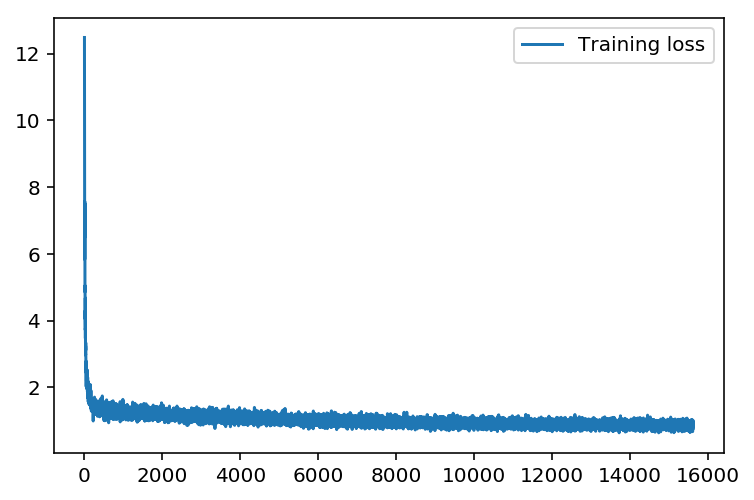

In [28]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

测试loss

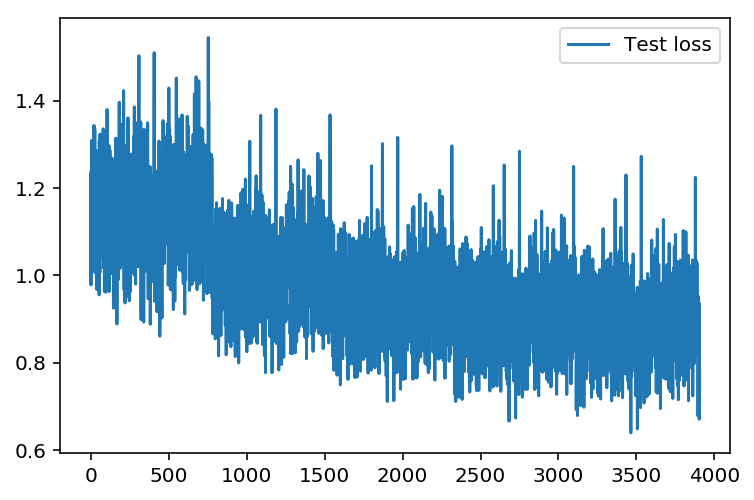

In [29]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

In [32]:
def get_tensors(loaded_graph):

    uid = loaded_graph.get_tensor_by_name("uid:0")
    user_gender = loaded_graph.get_tensor_by_name("user_gender:0")
    user_age = loaded_graph.get_tensor_by_name("user_age:0")
    user_job = loaded_graph.get_tensor_by_name("user_job:0")
    movie_id = loaded_graph.get_tensor_by_name("movie_id:0")
    movie_categories = loaded_graph.get_tensor_by_name("movie_categories:0")
    movie_titles = loaded_graph.get_tensor_by_name("movie_titles:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    dropout_keep_prob = loaded_graph.get_tensor_by_name("dropout_keep_prob:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    #两种不同计算预测评分的方案使用不同的name获取tensor inference
#     inference = loaded_graph.get_tensor_by_name("inference/inference/BiasAdd:0")
    inference = loaded_graph.get_tensor_by_name("inference/ExpandDims:0") 
    movie_combine_layer_flat = loaded_graph.get_tensor_by_name("movie_fc/Reshape:0")
    user_combine_layer_flat = loaded_graph.get_tensor_by_name("user_fc/Reshape:0")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, movie_combine_layer_flat, user_combine_layer_flat

指定用户和电影进行评分
这部分就是对网络做正向传播，计算得到预测的评分

In [33]:
def rating_movie(user_id_val, movie_id_val):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
    
        # Get Tensors from loaded model
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference,_, __ = get_tensors(loaded_graph)  #loaded_graph
    
        categories = np.zeros([1, 18])
        categories[0] = movies.values[movieid2idx[movie_id_val]][2]
    
        titles = np.zeros([1, sentences_size])
        titles[0] = movies.values[movieid2idx[movie_id_val]][1]
    
        feed = {
              uid: np.reshape(users.values[user_id_val-1][0], [1, 1]),
              user_gender: np.reshape(users.values[user_id_val-1][1], [1, 1]),
              user_age: np.reshape(users.values[user_id_val-1][2], [1, 1]),
              user_job: np.reshape(users.values[user_id_val-1][3], [1, 1]),
              movie_id: np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              movie_categories: categories,  #x.take(6,1)
              movie_titles: titles,  #x.take(5,1)
              dropout_keep_prob: 1}
    
        # Get Prediction
        inference_val = sess.run([inference], feed)  
    
        return (inference_val)

生成Movie特征矩阵
将训练好的电影特征组合成电影特征矩阵并保存到本地

In [34]:
loaded_graph = tf.Graph()  #
movie_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, movie_combine_layer_flat, __ = get_tensors(loaded_graph)  #loaded_graph

    for item in movies.values:
        categories = np.zeros([1, 18])
        categories[0] = item.take(2)

        titles = np.zeros([1, sentences_size])
        titles[0] = item.take(1)

        feed = {
            movie_id: np.reshape(item.take(0), [1, 1]),
            movie_categories: categories,  #x.take(6,1)
            movie_titles: titles,  #x.take(5,1)
            dropout_keep_prob: 1}

        movie_combine_layer_flat_val = sess.run([movie_combine_layer_flat], feed)  
        movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [35]:

movie_matricsmovie_ma  = pickle.load(open('movie_matrics.p', mode='rb'))

生成User特征矩阵
将训练好的用户特征组合成用户特征矩阵并保存到本地

In [36]:
loaded_graph = tf.Graph()  #
users_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, __,user_combine_layer_flat = get_tensors(loaded_graph)  #loaded_graph

    for item in users.values:

        feed = {
            uid: np.reshape(item.take(0), [1, 1]),
            user_gender: np.reshape(item.take(1), [1, 1]),
            user_age: np.reshape(item.take(2), [1, 1]),
            user_job: np.reshape(item.take(3), [1, 1]),
            dropout_keep_prob: 1}

        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)  
        users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [37]:
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

开始推荐电影
使用生产的用户特征矩阵和电影特征矩阵做电影推荐

推荐同类型的电影
思路是计算当前看的电影特征向量与整个电影特征矩阵的余弦相似度，取相似度最大的top_k个，这里加了些随机选择在里面，保证每次的推荐稍稍有些不同。

In [38]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
    
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keep_dims=True))
        normalized_movie_matrics = movie_matrics / norm_movie_matrics

        #推荐同类型的电影
        probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [40]:
recommend_same_type_movie(1202, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[1202 'Withnail and I (1987)' 'Comedy']
以下是给您的推荐：
1184
[1202 'Withnail and I (1987)' 'Comedy']
546
[550 'Threesome (1994)' 'Comedy|Romance']
2822
[2891 'Happy, Texas (1999)' 'Comedy']
2153
[2222 'Champagne (1928)' 'Comedy']
1617
[1663 'Stripes (1981)' 'Comedy']


{546, 1184, 1617, 2153, 2822}

推荐您喜欢的电影
思路是使用用户特征向量与电影特征矩阵计算所有电影的评分，取评分最高的top_k个，同样加了些随机选择部分。

In [41]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        #推荐您喜欢的电影
        probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])

        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     print(sim.shape)
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    #     sim_norm = probs_norm_similarity.eval()
    #     print((-sim_norm[0]).argsort()[0:top_k])
    
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])

        return results

In [47]:
recommend_your_favorite_movie(24, 10)

INFO:tensorflow:Restoring parameters from ./save
以下是给您的推荐：
2912
[2981 'Brother, Can You Spare a Dime? (1975)' 'Documentary']
1650
[1697 'Big Bang Theory, The (1994)' 'Crime']
1939
[2008 'This World, Then the Fireworks (1996)' 'Crime|Drama|Film-Noir']
3314
[3383 'Big Fella (1937)' 'Drama|Musical']
315
[318 'Shawshank Redemption, The (1994)' 'Drama']


{315, 1650, 1939, 2912, 3314}

看过这个电影的人还看了（喜欢）哪些电影
首先选出喜欢某个电影的top_k个人，得到这几个人的用户特征向量。
然后计算这几个人对所有电影的评分
选择每个人评分最高的电影作为推荐
同样加入了随机选择

In [63]:
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
        favorite_user_id = np.argsort(probs_user_favorite_similarity.eval())[0][-top_k:]
    #     print(normalized_users_matrics.eval().shape)
    #     print(probs_user_favorite_similarity.eval()[0][favorite_user_id])
    #     print(favorite_user_id.shape)
    
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        
        print("喜欢看这个电影的人是：{}".format(users_orig[favorite_user_id-1]))
        probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
        probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
    
    #     print(sim.shape)
    #     print(np.argmax(sim, 1))
        p = np.argmax(sim, 1)
        print("喜欢看这个电影的人还喜欢看：")

        results = set()
        while len(results) != 2:
            c = p[random.randrange(top_k)]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [64]:
recommend_other_favorite_movie(201, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[201 'Three Wishes (1995)' 'Drama']
喜欢看这个电影的人是：[[2154 'M' 25 12]
 [5763 'F' 25 1]
 [5669 'M' 56 1]
 [1669 'F' 25 17]
 [2202 'F' 1 10]
 [5155 'M' 25 16]
 [3008 'M' 18 4]
 [2292 'M' 50 15]
 [1763 'M' 35 7]
 [3031 'M' 18 4]
 [100 'M' 35 17]
 [2391 'M' 50 18]
 [1568 'F' 1 10]
 [3603 'F' 35 7]
 [3901 'M' 18 14]
 [3764 'M' 25 1]
 [5861 'F' 50 1]
 [4085 'F' 25 6]
 [85 'M' 18 4]
 [2338 'M' 45 17]]
喜欢看这个电影的人还喜欢看：
2912
[2981 'Brother, Can You Spare a Dime? (1975)' 'Documentary']
1650
[1697 'Big Bang Theory, The (1994)' 'Crime']


{1650, 2912}

以上就是实现的常用的推荐功能，将网络模型作为回归问题进行训练，得到训练好的用户特征矩阵和电影特征矩阵进行推荐。